In [13]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.planet import Planet


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialise `datacube` object
The main parameters are a 
* 2D** wavelength vector (K_orders, N_pixels)
* 3D flux matrix (K_orders, M_frames, N_pixels)

** assuming a common wavelength grid for each order, see Notebook XX for more details

In [14]:
# get example data
# or pass your own data with the required shape

In [15]:
file = '/home/dario/AstronomyLeiden/MRP/redcross/examples/data/spectra_harpsn.fits'

with fits.open(file) as hdul:
    hdul.info()
    meta = hdul[1].data
    wave = hdul[2].data
    flux = hdul[3].data
    
dc = Datacube(wlt=wave, flux=flux)
dc.airmass, dc.BERV, dc.MJD = meta.airmass, meta.BERV, meta.MJD    

print(dc.shape)

Filename: /home/dario/AstronomyLeiden/MRP/redcross/examples/data/spectra_harpsn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   247R x 3C   [D, D, D]   
  2                1 ImageHDU         7   (4096, 69)   float64   
  3                1 ImageHDU         8   (4096, 247, 69)   float32   
(69, 247, 4096)


### Select single order
Work with a single order "dco = DataCubeOrder" by passing an integer to the function `datacube.order(i)`

* Display stacked spectra as an image --> `dco.imshow()`

* Plot the time-average (i.e. master spectrum) --> `dco.plot()`

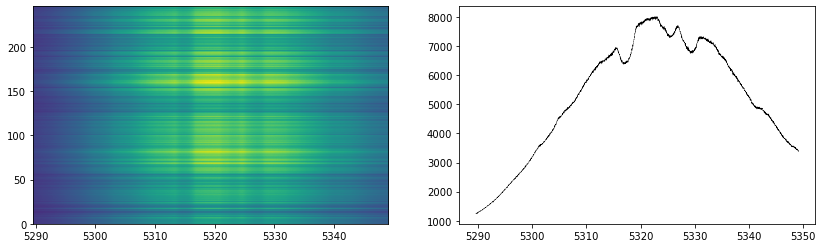

In [16]:
dco = dc.order(42)

fig, ax = plt.subplots(1,2,figsize=(14,4))
dco.imshow(ax=ax[0])
dco.plot(ax=ax[1], lw=0.25, c='k') # pass optional arguments accepted by plt.plot()
plt.show()

### Display all orders
For each order, plot the master spectrum

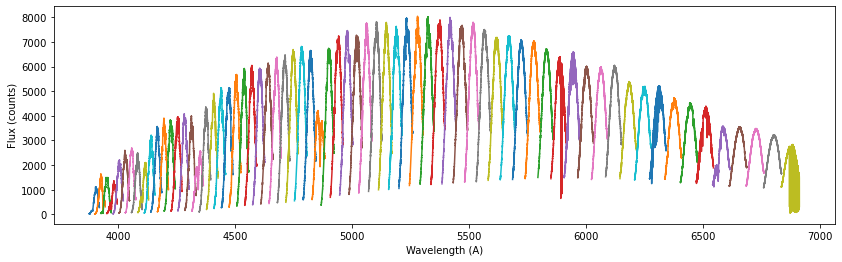

In [17]:
fig, ax = plt.subplots(1, figsize=(14,4))
for o in range(dc.nOrders):
    dco = dc.order(o).plot(ax=ax)

ax.set(xlabel='Wavelength (A)', ylabel='Flux (counts)')
plt.show()

### Basic reduction (for a single order)
The in-built functions can apply the following reduction steps directly to the datacube object.
Let's display the cube at each stage. Available reduction functions are:
* `normalise`: Divide each frame by its median flux
* `airmass_detrend`: For each wavelength channel, divide flux by a second-order polynomial fit between airmass and flux depth
* `high_pass_gaussian`: Keep only high-frequency signals (< window) by dividing each frame by a low-pass gaussian filter

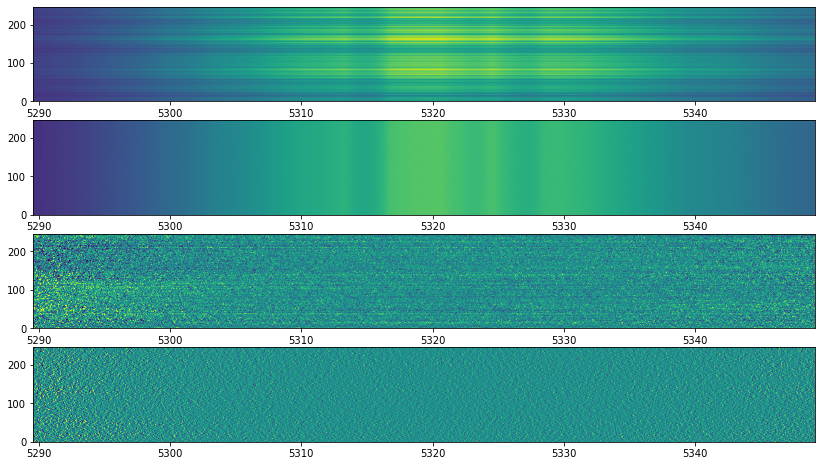

In [18]:
fig, ax = plt.subplots(4,figsize=(14,8))

# First select an order
dco = dc.order(42)
dco.imshow(ax=ax[0])

# Normalise
dco.normalise()
dco.imshow(ax=ax[1])

# Airmass detrend
dco.airmass_detrend()
dco.imshow(ax=ax[2], stretch=1.)

# High-pass filter
dco.high_pass_gaussian(15) # window in [pixels]
dco.imshow(ax=ax[3], stretch=1.)

plt.show()

### Reduction routine for a set of orders
Loop over different orders and store the flattened data in a "merged datacube" 

Reduced cube shape = (247, 36864)


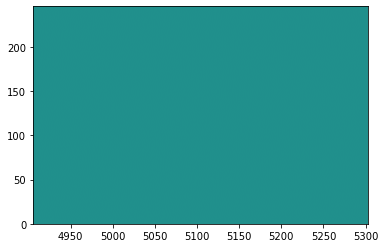

In [19]:
orders = np.arange(33,42)
wave_list = []
flux_list = []
for o in orders:
    print('Order {:}/{:}'.format(o, orders[0]+orders.size), end='\r')
    dco = dc.order(o)
    dco = dco.normalise().airmass_detrend().high_pass_gaussian(15)
    wave_list.append(dco.wlt)
    flux_list.append(dco.flux)
    
dcm = Datacube(wlt=np.hstack(wave_list), flux=np.hstack(flux_list)) # concatenate orders
dcm.imshow() # it should look "very" homogeneous ---> noise pattern
print('Reduced cube shape = {:}'.format(dcm.shape)) 

### Load atmospheric template

Filename: data/wasp189_fe_4000k.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (72646,)   float64   
  1                1 ImageHDU         6   (72646,)   float64   


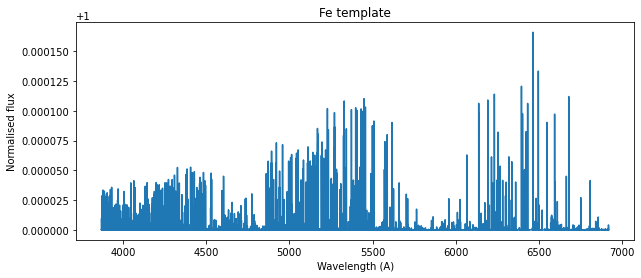

In [25]:
template_path = 'data/wasp189_fe_4000k.fits'
with fits.open(template_path) as hdul:
    hdul.info()
    twave, tflux = hdul[0].data,  hdul[1].data

# wavelength must be in the same units as data (A), 
# multiply by 10 to go from nm to A
# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(template.wlt, template.flux)
ax.set(xlabel='Wavelength (A)', ylabel='Normalised flux', title='Fe template')
plt.show()

### Cross-correlation

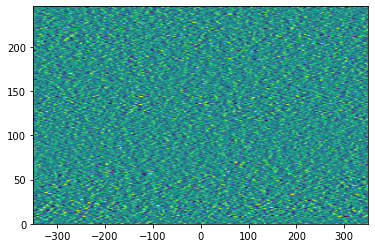

In [26]:
# define radial velocity lag vector
dRV = 1.
RVt = np.arange(-350,351, dRV) # the RV-step should be larger (or equal) to the instrument's resolution (in km/s)
ccf = CCF(rv=RVt, template=template)
ccf.run(dcm, weighted=True)
ccf.imshow()
plt.show()

### Kp-Vsys map

Horizontal slice at Kp = 199.5 km/s
Vertical slice at Vrest = 1.0 km/s


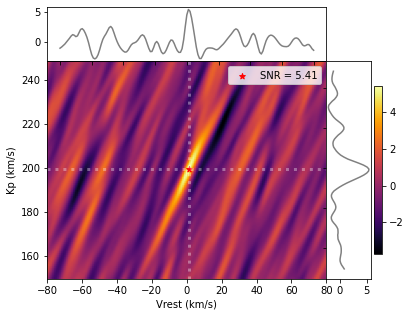

In [28]:
# load BERV, MJD data for each frame
planet = Planet('wasp189')
planet.BERV = dc.BERV
planet.MJD = dc.MJD

dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure()
plt.show()